<a href="https://colab.research.google.com/github/sayakpaul/robustness-vit/blob/master/analysis/attention_maps/CAMs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Setup

Reference: https://github.com/jacobgil/pytorch-grad-cam. 

In [ ]:
!wget -q https://storage.googleapis.com/download.tensorflow.org/data/imagenet_class_index.json
!gdown --id 14X0QkWoGRLUINT_iFKvs6ae20v3_f-yU

Downloading...
From: https://drive.google.com/uc?id=14X0QkWoGRLUINT_iFKvs6ae20v3_f-yU
To: /content/correct_image_paths.pkl
100% 2.02k/2.02k [00:00<00:00, 3.46MB/s]


In [ ]:
!gdown --id 1QtAJsTjBOf3CnrTzTTqP-nPnHcTc2g9E
!tar xf val.tar

Downloading...
From: https://drive.google.com/uc?id=1QtAJsTjBOf3CnrTzTTqP-nPnHcTc2g9E
To: /content/val.tar
6.75GB [01:07, 99.6MB/s]


In [ ]:
!pip install -q grad-cam timm ttach

In [ ]:
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.image import show_cam_on_image, \
                                         deprocess_image, \
                                         preprocess_image

import matplotlib.pyplot as plt
import numpy as np
import torch
import timm
import cv2
import pickle
import json
import os

## Utilities

In [ ]:
with open("imagenet_class_index.json", "r") as read_file:
    imagenet_labels = json.load(read_file)
    
MAPPING_DICT = {}
LABEL_NAMES = {}
for label_id in list(imagenet_labels.keys()):
    MAPPING_DICT[imagenet_labels[label_id][0]] = int(label_id)
    LABEL_NAMES[int(label_id)] = imagenet_labels[label_id][1]
    
IMAGENET_VAL_PATHS = pickle.loads(open("correct_image_paths.pkl", "rb").read())[:5]
IMAGENET_VAL_PATHS

['val/n02871525/ILSVRC2012_val_00003028.JPEG',
 'val/n04335435/ILSVRC2012_val_00004855.JPEG',
 'val/n04200800/ILSVRC2012_val_00018851.JPEG',
 'val/n01784675/ILSVRC2012_val_00013388.JPEG',
 'val/n04259630/ILSVRC2012_val_00014823.JPEG']

In [ ]:
bit_model = timm.create_model('resnetv2_101x3_bitm', pretrained=True)
vit_model = timm.create_model("vit_large_patch16_224", pretrained=True)

bit_model.to("cpu")
vit_model.to("cpu")

print("")

In [ ]:
def preprocess(image, mean, std):
    rgb_img = np.float32(image) / 255
    input_tensor = preprocess_image(rgb_img, mean=mean, std=std)
    return input_tensor

In [ ]:
def reshape_transform(tensor, height=14, width=14):
    result = tensor[:, 1 :  , :].reshape(tensor.size(0),
        height, width, tensor.size(2))

    # Bring the channels to the first dimension,
    # like in CNNs.
    result = result.transpose(2, 3).transpose(1, 2)
    return result

In [ ]:
def visualize(images, results, name):
    fig, ax = plt.subplots(ncols=4, nrows=2, figsize=(8, 4))
    for i in range(2):
        for j in range(4):
            ax[i, j].axis("off")
            if i == 0:
                _ = ax[i, j].imshow(images[j])
            elif i == 1:
                _ = ax[i, j].imshow(results[j][:, :, ::-1])
    
    fig.subplots_adjust(hspace=0.0, wspace=0.0)
    fig.savefig(f"{name}", dpi=300, bbox_inches="tight")

In [ ]:
def run_cam(rgb_image, target, cam):
    input_tensor = preprocess(rgb_image, mean=[0.5, 0.5, 0.5], 
                                                std=[0.5, 0.5, 0.5])
    input_tensor.to("cpu")
    grayscale_cam = cam(input_tensor=input_tensor, target_category=target)
    visualization = show_cam_on_image(rgb_image/255., grayscale_cam.squeeze())

    return visualization

## BiT CAMs

In [ ]:
target_layer = bit_model.stages[-1].blocks[-1] 
cam = GradCAM(model=bit_model, target_layer=target_layer, use_cuda=False,
                  reshape_transform=None)

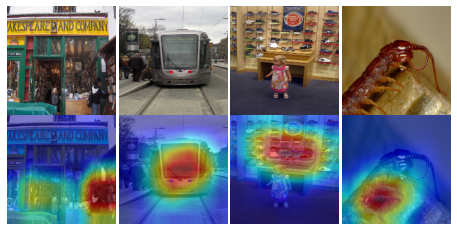

In [ ]:
images = []
results = []
predictions = []

for path in IMAGENET_VAL_PATHS:
    image = plt.imread(path)
    image = cv2.resize(image, (224, 224))
    
    target = MAPPING_DICT[path.split("/")[1]]
    visualization = run_cam(image, target, cam)

    images.append(image)
    results.append(visualization)
    predictions.append(target)

visualize(images[:-1], results[:-1], "gradcam_bit.png")

## ViT CAMs

In [ ]:
target_layer = vit_model.blocks[-1].norm1
cam = GradCAM(model=vit_model, target_layer=target_layer, use_cuda=False,
                  reshape_transform=reshape_transform)

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/module.py:795: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


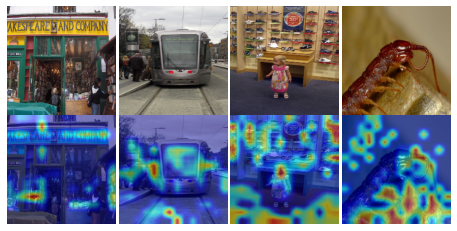

In [ ]:
images = []
results = []
predictions = []

for path in IMAGENET_VAL_PATHS:
    image = plt.imread(path)
    image = cv2.resize(image, (224, 224))
    
    target = MAPPING_DICT[path.split("/")[1]]
    visualization = run_cam(image, target, cam)

    images.append(image)
    results.append(visualization)
    predictions.append(target)

visualize(images, results, "gradcam_vit.png")